In [1]:
# switch kernel to pytensor5 here
import cobra
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pytensor
import pymc as pm

import emll

import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Setting up groundtruth values and loading in data

In [2]:
df = pd.read_csv('../data/Simplified_Teusink_yeast_1.05.csv')
r = te.loada('../models/Simplified_Teusink_yeast.ant')

r.steadyState()
# N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(r.getReactionIds())]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(r.getReactionIds())]/df[internal].loc[0]
vn = df[fluxes].loc[1:len(r.getReactionIds())]/df[fluxes].loc[0]
yn = df[external].iloc[-(len(vn)):]/df[external].loc[0]


In [3]:
# load cobra version of model
model = cobra.io.read_sbml_model('../models/Simplified_Teusink_yeast_cobra.xml')
N = cobra.util.create_stoichiometric_matrix(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


No objective coefficients in model. Unclear what should be optimized


In [4]:
# Set up the Bayesian inference
r_compartments = [r.compartments if 'e' not in r.compartments else 't' for r in model.reactions]

for rxn in model.exchanges:
    r_compartments[model.reactions.index(rxn)] = 't'

m_compartments = [m.compartment for m in model.metabolites]
internal_mets = [i for i in model.metabolites if i.compartment!='e']
rxnNames = [i.id for i in model.reactions]
v_inds = np.arange(0,len(v_star))
n_exp = vn.shape[0]


In [5]:
# Set up the Bayesian inference
r_compartments = [r.compartments if 'e' not in r.compartments else 't' for r in model.reactions]

for rxn in model.exchanges:
    r_compartments[model.reactions.index(rxn)] = 't'

m_compartments = [m.compartment for m in model.metabolites]
internal_mets = [i for i in model.metabolites if i.compartment!='e']
rxnNames = [i.id for i in model.reactions]
v_inds = np.arange(0,len(v_star))
n_exp = vn.shape[0]


In [6]:
Ex = emll.create_elasticity_matrix(model)

Ey = np.zeros((16, 3))
Ey[13, 0] = -1  # glco on vGLT
Ey[14, 1] = 1  # etoh on vADH
Ey[15, 2] = 1  # gly on vG3PDH

ll = emll.LinLogLeastNorm(N, Ex, Ey, v_star, driver='gelsy')

In [7]:
from emll.util import initialize_elasticity
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', initialize_elasticity(N, 'ex', b=0.05, sigma=1, alpha=5))
    Ey_t = pm.Deterministic('Ey', initialize_elasticity(-Ey.T, 'ey', b=0.05, sigma=1, alpha=5))


In [8]:
with pymc_model:
        
    # Error priors. 
    v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
    x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1)

    # Calculate steady-state concentrations and fluxes from elasticities
    chi_ss, v_hat_ss = ll.steady_state_pytensor(Ex_t, Ey_t, en.values, yn.values)

    # Error distributions for observed steady-state concentrations and fluxes
    chi_obs = pm.Normal('chi_obs', mu=chi_ss, sigma=x_err, observed=xn)
    v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss[:, 0].squeeze(),
                          sigma=v_err, observed=vn.squeeze())

In [9]:
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = pm.fit(n=250000)

c:\Users\user\miniconda3\envs\pytensor5\lib\site-packages\pytensor\scalar\basic.py:2932: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 371.08


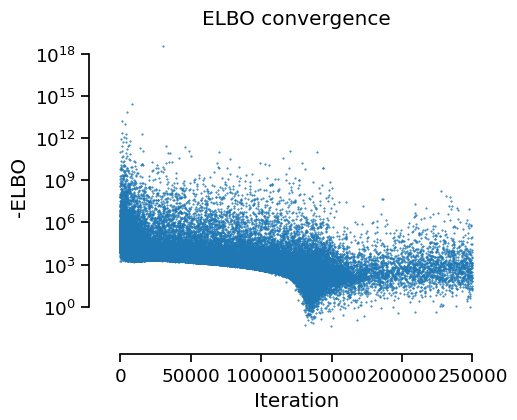

In [10]:
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4),dpi=100)
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    plt.yscale("log")
    
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('ELBO convergence')

In [17]:
with pymc_model:
    advi.fit(n=250000)

c:\Users\user\miniconda3\envs\pytensor5\lib\site-packages\pytensor\scalar\basic.py:2932: RuntimeWarning:

invalid value encountered in log



In [11]:
idata = approx.sample(1000)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ex_kinetic_entries[0],1.295,0.293,0.717,1.798,0.009,0.007,989.0,1025.0,NaN
ex_kinetic_entries[1],1.143,0.224,0.734,1.578,0.007,0.005,1033.0,1024.0,NaN
ex_kinetic_entries[2],0.661,0.526,-0.348,1.569,0.018,0.013,883.0,764.0,NaN
ex_kinetic_entries[3],1.369,0.548,0.372,2.389,0.017,0.012,1034.0,845.0,NaN
ex_kinetic_entries[4],0.918,0.644,-0.290,2.108,0.020,0.015,997.0,1062.0,NaN
...,...,...,...,...,...,...,...,...,...
"Ey[14, 1]",-0.059,0.051,-0.150,0.033,0.001,0.001,1239.0,849.0,NaN
"Ey[14, 2]",-0.012,0.036,-0.082,0.050,0.001,0.001,1019.0,983.0,NaN
"Ey[15, 0]",0.003,0.024,-0.040,0.049,0.001,0.001,880.0,1023.0,NaN
"Ey[15, 1]",0.006,0.025,-0.040,0.053,0.001,0.001,965.0,981.0,NaN


In [12]:
g = az.summary(idata)['mean'].reset_index()
g.columns = ['elasticity', 'mean']
pd.DataFrame(g[g.elasticity.str.contains("Ex")]['mean'].values.reshape((16,11)), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds())

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE
vGLK,1.295,-1.143,0.003,0.001,-0.007,0.004,-0.006,-0.007,0.007,-0.000,-0.013
vPGI,-0.001,0.661,-1.369,-0.015,-0.020,-0.011,-0.009,0.000,0.003,0.000,-0.002
vGLYCO,0.001,0.918,0.014,0.008,-0.004,-0.000,-0.003,-0.005,-0.005,-0.005,-0.006
vTreha,0.016,0.927,0.016,0.011,0.004,0.008,0.001,-0.012,-0.005,-0.011,-0.015
vPFK,-0.005,0.012,0.722,-1.282,-0.014,-0.008,-0.014,0.001,0.005,-0.007,0.001
vALD,0.007,0.002,0.017,1.039,-1.128,-0.005,0.004,-0.003,-0.001,-0.004,-0.010
vGAPDH,0.005,0.006,0.009,0.011,0.849,-1.240,-0.012,-0.017,-0.008,-0.010,-0.017
vPGK,-0.003,0.000,0.009,0.014,0.007,1.099,-1.112,-0.010,-0.013,-0.012,-0.013
vPGM,0.000,0.010,0.002,0.019,0.010,0.018,1.281,-0.888,-0.006,-0.007,-0.009
vENO,0.006,-0.003,-0.001,0.010,0.002,0.006,0.008,1.462,-0.765,0.004,-0.008


In [14]:
# ground truth elasticity values
ex

               GLCi,      G6P,       F6P,     F16P,      TRIO,       BPG,      P3G,       P2G,       PEP,       PYR,      ACE
vGLK   [[   1.44964, -1.43765,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vPGI    [         0,  1.40347, -0.953057,        0,         0,         0,        0,         0,         0,         0,        0],
vGLYCO  [         0,        1,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vTreha  [         0,        1,         0,        0,         0,         0,        0,         0,         0,         0,        0],
vPFK    [         0,        0,   1.38303, -1.03688,         0,         0,        0,         0,         0,         0,        0],
vALD    [         0,        0,         0,  1.10649, -0.823896,         0,        0,         0,         0,         0,        0],
vGAPDH  [         0,        0,         0,        0,  0.969712, -0.705532,        0,         0,         0, 